In [84]:
# Computing METRICS:
# This script uses functional roi niftis (converted from.img files and scaled in FSL to correct
# size in each dimension). These parcels are used as binary masks on output from first-level 
# analysis. 
# This yields a hypothesis space for each roi (same location for every 
# subject). These ROI's are face parcels from the Kanwisher website http://web.mit.edu/bcs/nklab/GSS.shtml
# with the exception of DMFPC and AMY (taken from saxelab).

## MAGNITUDE
# The top 50 voxels are then selected from these hypothesis space based on highest t-statistic
# (no threshold, and no constraint on contiguity). This defines the ROIs per subject.
# The corresponding con values are averaged as the mean magnitude summary statistic.

## LATERALIZATION
# Different mask used: left space computed as voxels within left parcel and flipped right parcel, 
# then right space defined as voxels within right parcel and flipped left parcel.
# Count # voxels above a certain p value (0.01 or 0.001) to do calculations: L - R / L + R

## MULTIVARIATE VECTORS
# This is computed over entire hypothesis space, as a vector of all contrast values within the parcel.

## SAVES: roi_individual_masks & roi_contrast_values (top 50 voxels per subject), 
# and text files per metric computations that can be opened as a dataframe.

# In directory: Parcel_binary_masks (for lateralization calcualations)
# /om/user/rezzo/OpenAutism/analysis_data/SYMMETRICAL_MASKS/
# In directory Assymmerical_parcels (for other metrics)
# /om/user/rezzo/OpenAutism/analysis_data/MASKS/

## TO DO:
# double check all --go through and plot everything.
# take into account multiple runs for tempo_var and inter_cor, and save per RUN then average.
# how are we combining temporal variance across runs and experiments? FACE vs. non-face?

# Note : to convert Analyze format to Nifti format:
# load in header, image (and .mat) files into the folder
# fslchfiletype NIFTI_GZ RTPJ_xyz.nii.gz RTPJ_xyz


In [85]:
# subject look up table conversion (IGNORING undescores)
def Convert_Subname(Newname):
    tmp_root = '/om/user/rezzo/Subject_Conversion_Table.csv'

    with open(tmp_root, "r") as tsv:
        for line in csv.reader(tsv,  delimiter = ","):
            if Newname == line[0]:
                Oldname = line[1]
            else:
                continue
    return Oldname  

In [86]:
# add error msg for rois smaller that N (specificied voxels)

def nan_largestval(ary, n):
    flat = ary.flatten()                      # transform to one array
    values = -np.sort(-flat)                  # order values greatest to least, nans at the end
    idx = (-flat).argsort()[:n]               # obtain indices of the values in flat array
    idx2 = np.unravel_index(idx, ary.shape)   # transform indices to original array
    return [values[0:n], idx2]                # return values, indices

In [87]:
# add error msg for rois smaller that N (specificied voxels)

def nan_abovethresh(ary, thresh):
    flat = ary.flatten()                     # transform to one array
    count = np.sum(flat<thresh)              # count voxels greater than thresh
    return [count]                           # return count                                     

In [88]:
# to return a list of floats from a text file  

def txt2list(file,details):
    txtfile = open(file,'r')
    details = []
    for line in txtfile:
        details.extend([float(i) for i in line.rstrip('\n').split()])
    return details

In [89]:
# to transform pearson's R to fisher's Z

def pearson2fisher(pearsonR):
    fisherZ = 0.5*(np.log(1+pearsonR) - np.log(1- pearsonR)) # np.log is NATURAL LOG!*
    return fisherZ

In [90]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [91]:
# find out first element of design file
def Design_file(tmp_root):
    array = []
    with open(tmp_root, "r") as tsv:
        for line in csv.reader(tsv,  delimiter = "\t"):
            array.append(line[3])
    if array[1] == 'belief':
        return "1"
    elif array[1] == 'photo':
        return "0"

In [96]:
##### PATHWAYS

roi_size = 50; # of voxels you want in ROI

#import modules
from os.path import join as pjoin, split as psplit
import os
import numpy as np
import matplotlib
from statistics import mean
import csv
from glob import glob
import re
import pandas as pd
from scipy import stats
import warnings as warn
import operator
import itertools
from nipype.interfaces import fsl
import nibabel as nib
from nibabel.testing import data_path
import nilearn
from nilearn.masking import apply_mask
from nilearn import plotting


pilot = 1


# look inside the OA folder and list all subjects

if pilot is 1:
    main_root = '/om/user/rezzo/OpenAutism/pilot_data/'
    roi_index = ['LDMPFC','RDMPFC','LFFA','RFFA','LSTS','RSTS','LAMY','RAMY', 'LTPJ','RTPJ']
    lat_index = ['MPFC','FFA','STS','AMY','TPJ']

else:
    main_root = '/om/user/rezzo/OpenAutism/analysis_data/'
    roi_index = ['LDMPFC','RDMPFC','LFFA','RFFA','LSTS','RSTS','LAMY','RAMY']
    lat_index = ['MPFC','FFA','STS','AMY']

all_subjects = glob(main_root+"/SUBJECTS/*/")
subject_list = []

# create list of subject in folder
for subs in range(0, len(all_subjects)):
    m = re.search('SAX_OA_(.+?)/', all_subjects[subs])
    if m:
        found = m.group(1)
        subject_list.append('SAX_OA_'+found) # subject is the list with all subject names.

# Here is the sorted list of OA subject names        
subject_list.sort

# load list of subjects to include after motion outlier exclusion
good_subjects = main_root+'MOTION_INFO/Runs_LenientMotionFiltered.tsv'
# GS=pd.read_csv(good_subjects, sep='\t', header=None)
# GS




In [95]:
######## MAGNITUDE AND LATERALIZATION ##########

debug1 = [] # keep for now (in case)
debug2 = []
debug3 = []
debug4 = []
debug5 = []
debug6 = []


subject_list = ['SAX_OA_006']

# location of images 
roiroot = main_root+'MASKS/STANDARD_MASKS/'
biroiroot = main_root+'MASKS/LATERAL_MASKS/'
debug_list = []

for subject in subject_list:
    warn.filterwarnings("ignore",category =RuntimeWarning)
    imgroot = main_root+'SUBJECTS/'+subject+'/derivatives/standard/'
    temp_list = os.listdir(imgroot+'first_level_analyses')

    task_list = []
    
    for items in temp_list:
        TL = find_between(items, "tstat1_",'_run_',) 
        if TL is not "":
            task_list.append(TL)
    
    task_list = ['tomloc'] # temporary for pilot !!!!!!!!
    
    for task in task_list:
        runs = []
        initial_csv = 0
        
        for items in temp_list:
            st = find_between(items, "tstat1_"+task+'_run_', '.nii.gz') 
            if st is not "":
                runs.append("00"+st)
        
        for run in runs:
            
            # now check if it is a motion outlier:
            # need to also find a way to average runs together, and save tasks separately.
            
            if subject+task+run in open(good_subjects).read():
                #print("good_subject "+subject+task+run)
                debug1.append(subject+task+run)
                initial_csv = initial_csv + 1
                T_image = os.path.join(imgroot+'first_level_analyses/'+'tstat1_'+task+'_run_'+run[-1]+'.nii.gz')
                CON_image = os.path.join(imgroot+'first_level_analyses/'+'cope1_'+task+'_run_'+run[-1]+'.nii.gz')
                Z_image = os.path.join(imgroot+'first_level_analyses/zstat1_'+task+'_run_'+run[-1]+'.nii.gz')
                # list number of t-stat files (== # runs)


                # load t-image
                t_image = nib.load(T_image)
                t_data = np.array(t_image.dataobj)

                # load z image
                z_image = nib.load(Z_image)
                z_data = np.array(z_image.dataobj)
                
                
                # load con image
                con_image = nib.load(CON_image)
                CON_data = np.array(con_image.dataobj)

                # for tomloc debugging, load design file and read the first line
                file = imgroot+'first_level_analyses/BOLD_data/design_'+task+'_run-'+run+'.tsv'
                debug5.append(Design_file(file))
                
                
                # FIND TOP 50 voxels according to t-value in each ROI

            #     roi_index = ['LDMPFC','RDMPFC','LFFA','RFFA','LSTS','RSTS','LAMY','RAMY']

                # initialize list for magnitudes and positions
                mag_per_roi = [[]] * len(roi_index)
                pos_per_roi = [[]] * len(roi_index)
                lat_lenient = [[]] * len(lat_index)
                count_lenient = [[]] * len(lat_index)
                lat_strict = [[]] * len(lat_index)
                count_strict = [[]] * len(lat_index)
                
                count = -1

                for roi in roi_index:

                    count = count + 1

                    if roi is 'LDMPFC':
                        parcel_file = os.path.join(data_path, roiroot + 'lDMPFC_xyz_FSL_space.nii.gz')
                    if roi is 'RDMPFC':
                        parcel_file = os.path.join(data_path, roiroot + 'rDMPFC_xyz_FSL_space.nii.gz')
                    elif roi is 'LFFA':
                        parcel_file = os.path.join(data_path, roiroot + 'lFFA_FSL_space.nii.gz')
                    elif roi is 'RFFA':
                        parcel_file = os.path.join(data_path, roiroot + 'rFFA_FSL_space.nii.gz')
                    elif roi is 'LSTS':
                        parcel_file = os.path.join(data_path, roiroot + 'lSTS_FSL_space.nii.gz')
                    elif roi is 'RSTS':
                        parcel_file = os.path.join(data_path, roiroot + 'rSTS_FSL_space.nii.gz')
                    elif roi is 'LAMY':
                        parcel_file = os.path.join(data_path, roiroot + 'lAMY_xyz_FSL_space.nii.gz')
                    elif roi is 'RAMY':
                        parcel_file = os.path.join(data_path, roiroot + 'rAMY_xyz_FSL_space.nii.gz')
                    elif roi is 'LTPJ':
                        parcel_file = os.path.join(data_path, roiroot + 'lTPJ_FSL_space.nii.gz')
                    elif roi is 'RTPJ':
                        parcel_file = os.path.join(data_path, roiroot + 'rTPJ_FSL_space.nii.gz')

                    PARCEL = nib.load(parcel_file)
                    binary_data = np.array(PARCEL.dataobj)

                    ###################################################
                    ###### multiply the t-image by the parcel mask

                    # make all values in binary mask = 0 to NAN
                    binary_data[binary_data == 0] = 'nan'

                    #save as a flattened array
                    roi_con = CON_data*binary_data #just added this
                    MVPA_array = roi_con.flatten()
                    np.save(imgroot+'second_level_analyses/multivariate/MVPA_array', MVPA_array)

                    #multiply t-image by roi masks;
                    roi_hs = t_data*binary_data
                    roi_hs = roi_hs.astype('float')

                    ########################################################
                    #### find top N t-values within this space to define ROI

                    #find highest values in the hypothesis space (t-values of the ROI)
                    [values, indices] = nan_largestval(roi_hs, roi_size)

                    #multiply roi_mask with con image to obtain magnitude of contrast
                    #CHECK TO SEE IF THIS IS CORRECT
                    #Should I make a new binary mask per subject per ROI?
                    roi_mask = np.zeros(shape=roi_hs.shape)
                    binary_data[binary_data == 'nan'] = 0 #just added
                    # initialize list for indices

                    tmp_list_X = []
                    tmp_list_Y = []
                    tmp_list_Z = []

                    # SAVE BINARY MASK OF SUBJECT-SPECIFIC ROI (50 voxels)
                    for hh in range(roi_size):
                        roi_mask[indices[0][hh],indices[1][hh],indices[2][hh]] = 1  ############# plot this
                        tmp_list_X.append(indices[0][hh])
                        tmp_list_Y.append(indices[1][hh])
                        tmp_list_Z.append(indices[2][hh])

                    roi_img = nib.Nifti1Image(roi_mask, PARCEL.affine, PARCEL.header)

                    fname = pjoin(imgroot+'second_level_analyses/MISC/individual_roi_masks/'+roi+'_indiv_roi_mask_run'+run)
                    nib.save(roi_img, fname)


                    # might need to add information about location of these voxels (indices per ROI)?
                    # LATER : save these locations per subject
                    X = int(np.round(np.mean(tmp_list_X)))
                    Y = int(np.round(np.mean(tmp_list_Y)))
                    Z = int(np.round(np.mean(tmp_list_Z)))
                    location = [X, Y, Z]

                    pos_per_roi[count] = location      ################# IS THIS HOW TO MEASURE POSITION?

                    # exclude zeros from mean
                    roi_contrast = CON_data*roi_mask
                    roi_mask[roi_mask == 0] = 'nan'
                    roi_contrast = CON_data*roi_mask
                    means = np.nanmean(roi_contrast)
                    mag_per_roi[count] = means        ##################
                    #print(means) #MEAN MAGNITUDE

                    # Save con values in the top 50 voxels
                    Top50voxels = roi_contrast.flatten()
                    Top50voxels = Top50voxels[~np.isnan(Top50voxels)]
                    # exclude nans and save to n array
                    np.save(imgroot+'second_level_analyses/magnitude/'+subject+task+run+'_Top50voxels_contrast_'+roi, Top50voxels)

                ############################# LATERALIZATION ###############################

                # (NEW PARCELS created by summing hypothesis space 
                # and flipped opposite space, see below for fsl commands to obtain the final space)
                # fslswapdim data -x y z flip_data ... where data is rFFA, lFFA, rSTS, lSTS
                # fslmaths mask1 -add mask2 -bin output ... (e.g. mask1 = rFFA original, mask 2 = lFFA flipped)
         
                count = -1
                
                for roi in lat_index:
                    count = count + 1
                    if roi is 'MPFC':
                        combined_left = os.path.join(data_path, biroiroot + 'lDMPFC_lateral_FSL_space.nii.gz')
                        combined_right = os.path.join(data_path, biroiroot + 'rDMPFC_lateral_FSL_space.nii.gz') 
                    elif roi is 'FFA':
                        combined_left = os.path.join(data_path, biroiroot + 'lFFA_lateral_FSL_space.nii.gz')
                        combined_right = os.path.join(data_path, biroiroot + 'rFFA_lateral_FSL_space.nii.gz')   
                    elif roi is 'STS':
                        combined_left = os.path.join(data_path, biroiroot + 'lSTS_lateral_FSL_space.nii.gz')
                        combined_right = os.path.join(data_path, biroiroot + 'rSTS_lateral_FSL_space.nii.gz')
                    elif roi is 'AMY':
                        combined_left = os.path.join(data_path, biroiroot + 'lAMY_lateral_FSL_space.nii.gz')
                        combined_right = os.path.join(data_path, biroiroot + 'rAMY_lateral_FSL_space.nii.gz')
                    elif roi is 'TPJ':
                        combined_left = os.path.join(data_path, biroiroot + 'lTPJ_lateral_FSL_space.nii.gz')
                        combined_right = os.path.join(data_path, biroiroot + 'rTPJ_lateral_FSL_space.nii.gz')

                    LEFT_PARCEL = nib.load(combined_left)
                    left_binary_data = np.array(LEFT_PARCEL.dataobj)

                    RIGHT_PARCEL = nib.load(combined_right)
                    right_binary_data = np.array(RIGHT_PARCEL.dataobj)


                    ###################################################
                    ###### multiply the t-image by the hypothesis space

                    # make all values in binary mask = 0 to NAN
                    # doing this prior to multiplication prevents -0s (python 2)
                    left_binary_data[left_binary_data == 0] = 'nan'
                    right_binary_data[right_binary_data == 0] = 'nan'

                    p_values_1 = stats.norm.sf(abs(z_data)) #one-sided
                    p_values_2 = stats.norm.sf(abs(z_data))*2 #twosided

                    #multiply p-values by roi masks;
                    left_roi_hs = (p_values_2)*left_binary_data
                    right_roi_hs = (p_values_2)*right_binary_data

                    #convert to float
                    left_roi_hs = left_roi_hs.astype('float')
                    right_roi_hs = right_roi_hs.astype('float')                  

                    #############
                    thresh1 = 0.01
                    #count number of voxels on the left that are p < 0.01
                    [total_left1] = nan_abovethresh(left_roi_hs, thresh1)

                    #count number of voxels on the right that are p < 0.01
                    [total_right1] = nan_abovethresh(right_roi_hs, thresh1)

                    count_lenient[count] = total_left1 + total_right1

                    debug3.append(total_left1)
                    debug4.append(total_right1)
                    
                    #############
                    thresh2 = 0.001
                    #count number of voxels on the left that are p < 0.001
                    [total_left2] = nan_abovethresh(left_roi_hs, thresh2)

                    #count number of voxels on the right that are p < 0.001
                    [total_right2] = nan_abovethresh(right_roi_hs, thresh2)

                    count_strict[count] = total_left2 + total_right2

                    ##final calculations of lateralization
                    # -1 means right dominant and 1 means left dominant, 0 means bilaterial
                    # for p < 0.01

                    if float(total_left1 + total_right1) == 0:
                        lat_lenient[count] = 0.0
                    else:
                        Lat1 = float(total_left1 - total_right1) / float(total_left1 + total_right1)
                        lat_lenient[count] = Lat1

                    # for p < 0.001
                    if float(total_left2 + total_right2) == 0:
                        lat_strict[count] = 0.0
                    else:
                        Lat2 = float(total_left2 - total_right2) / float(total_left2 + total_right2)
                        lat_strict[count] = Lat2
                
           ################################## MAG ################################
                    
                    
                # save means and locations to DataFrame (data library)
                pd.set_option('display.max_colwidth', -1)

                mag_init = mag_per_roi
                mag_init.extend(['Mean contrast magnitude of the top 50 voxels by t-value'])

                Mdataframe_init = ['MAG_' + s for s in roi_index]
                Mdataframe_init.extend(['Description'])
                ##
                Msub_measures = pd.DataFrame([mag_init],
                                           columns = Mdataframe_init)

                Msub_measures.rename(index={0: 'Magnitude'})

                print(subject+task+run)
                # save this Dataframe as a csv file and as the dataframe
                if initial_csv == 1:
                    Msub_measures.to_csv(imgroot+'second_level_analyses/magnitude/'+subject+task+'_MAG_SUM_STATS.csv', index=False)
                    #print("first_run")
                else:
                    Msub_measures.to_csv(imgroot+'second_level_analyses/magnitude/'+subject+task+'_MAG_SUM_STATS.csv', mode='a', index=False, header=False)
                    #print("second_run")
                
                ## LATER: SAVE POSITION TOO
                #[pos_per_roi[0], pos_per_roi[1],pos_per_roi[2],pos_per_roi[3],pos_per_roi[4],pos_per_roi[5],pos_per_roi[6], pos_per_roi[7],'XYZ average position of the top 50 voxels by t-value (MNI-152)']
            
                ################################ LAT ##################################
            
                pd.set_option('display.max_colwidth', -1)

                lat_init = lat_lenient
                debug2.append(lat_init[3:5])
                lat_init2 = lat_strict
                lat_init.extend(['Lateralization index based on voxel selection with p < 0.01 (left count - right count / left and right count)'])
                lat_init2.extend(['Lateralization index based on voxel selection with p < 0.001 (left count - right count / left and right count)'])

                Ldataframe_init = ['LAT_' + s for s in lat_index]
                Ldataframe_init.extend(['Description'])
                    ##
                Lsub_measures = pd.DataFrame([lat_init],
                                               columns = Ldataframe_init)
                Lsub_measures2 = pd.DataFrame([lat_init2],
                                               columns = Ldataframe_init)

                Lsub_measures.rename(index={0: 'Laterality Index (p < 0.01)'})
                Lsub_measures2.rename(index={0: 'Laterality Index (p < 0.001)'})

                #save this Dataframe as a csv file and as the dataframe
                
                if initial_csv == 1:
                    Lsub_measures.to_csv(imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT_SUM_STATS.csv', index=False)
                    Lsub_measures2.to_csv(imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT2_SUM_STATS.csv', index=False)
                else:
                    Lsub_measures.to_csv(imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT_SUM_STATS.csv', mode='a', index=False, header=False)
                    Lsub_measures2.to_csv(imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT2_SUM_STATS.csv', mode='a', index=False, header=False)
                
                ## count variables to save :: separately
                count_init = count_lenient
                count_init.extend(['Total count based on voxel selection with p < 0.01 (left + right)'])
                count_init2 = count_strict
                count_init2.extend(['Total count based on voxel selection with p < 0.001 (left + right)'])

                count_measures1 = pd.DataFrame([count_init],
                                               columns = Ldataframe_init)
                count_measures2 = pd.DataFrame([count_init2],
                                               columns = Ldataframe_init)

                #print(lat_init[3:5])
                #print(count_init[3:5])
                # rename column to total count
                if initial_csv == 1:
                    count_measures1.to_csv(imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT_COUNT_STATS.csv', index=False)
                    count_measures2.to_csv(imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT2_COUNT_STATS.csv', index=False)
                else:
                    count_measures1.to_csv(imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT_COUNT_STATS.csv', mode='a', index=False, header=False)
                    count_measures2.to_csv(imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT2_COUNT_STATS.csv', mode='a', index=False, header=False)
            
            
                #####################################################################
            
            # if no runs are good quality
            #else:
                #print("motion_outlier "+subject+task+run)
       
    
        file_list = [imgroot+'second_level_analyses/magnitude/'+subject+task+'_MAG_SUM_STATS.csv', imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT_SUM_STATS.csv',
                     imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT2_SUM_STATS.csv', imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT_COUNT_STATS.csv',
                    imgroot+'second_level_analyses/lateralization/'+subject+task+'_LAT2_COUNT_STATS.csv']
        
        for file in file_list:
            # now average all MAG runs together
            try:
                df = pd.read_csv(file)
                ex = pd.DataFrame(df.mean())
                ex = ex.transpose()
                ex.to_csv(file[:-4]+'_final.csv', index=False)
            except FileNotFoundError:
                print("No Valid Runs for "+subject+task)


/opt/conda/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


SAX_OA_006tomloc002


In [124]:

sub_measures
sub_measures.rename(index={0: 'Laterality Index (p < 0.01)', 1: 'Total count (p < 0.01)',
               2: 'Laterality Index (p < 0.01)', 3: 'Total count (p < 0.01)'})

,LAT_MPFC,LAT_FFA,LAT_STS,LAT_AMY,LAT_TPJ,Description
Laterality Index (p < 0.01),1.0,1.0,0.549296,-1.0,0.655172,Lateralization index based on voxel selection with p < 0.01 (left count - right count / left and right count)


In [122]:
count_measures1

,LAT_MPFC,LAT_FFA,LAT_STS,LAT_AMY,LAT_TPJ,Description
0,0,0,13,0,0,Total count based on voxel selection with p < 0.01 (left + right)


In [98]:
######## for intrasubject variability indexing ###########

task = 'tomloc'
run = '_run-001'

fpath = imgroot+'first_level_analyses/BOLD_data/design_'+task+run+'.tsv'
designfile = pd.read_csv(fpath, sep='\t')
TR = 2 #make this a file per experiment (later)
DISCRETE_POINTS = 5 # in TR: figure out best way to have indices for the future and make new ones adding (1,2,3,4,5)
# making them absolute so they remain in same place relative to canonical hrf. 12 is max because one experiment
# has a run time of 12 sec (CAN CHANGE THIS LATER).

# MAKE EXCEPTION FOR ALL EVENT-RELATED DESIGNS + add average all runs

unique = designfile.trial_type.unique()

onset_list = [[]]*len(unique)
shifted_onsets = [[]]*len(unique)
duration_list = [[]]*len(unique)
count = -1
#print(unique)
designfile  

final_exp_points = [[[]]* DISCRETE_POINTS]*len(unique)  ## make sure this allows for +2 conditions 
    
for element in unique:
    
    # create list specific to condition
    count = count + 1
    # write a list of all corresponding onset values to that element
    onset_list[count] = designfile.loc[designfile[designfile['trial_type'] == element].index.tolist(),'onset']
    duration_list[count] = designfile.loc[designfile[designfile['trial_type'] == element].index.tolist(),'duration']
    #offset_list[count] = onset_list[count] + duration_list[count]
    onset_list[count] = [ np.round(x) for x in onset_list[count]] 
    
    # the TR INDEX
    shifted_onsets[count] = (designfile.loc[designfile[designfile['trial_type'] == element].index.tolist(),'onset'] + TR) / 2
    shifted_onsets[count] = [ np.round(x) for x in shifted_onsets[count]] # offset rounded.
    shifted_onsets[count] = [ int(x) for x in shifted_onsets[count]]

# print out warning if duration is shorter/longer than should be
MIN_DUR = np.min(duration_list)
     
if DISCRETE_POINTS >= MIN_DUR/TR:
    print("WARNING: Run duration should be longer that time point selection. If event-related, skip. Otherwise adjust the DISCRETE_POINTS")

# print(shifted_onsets)
  
# initialize new lists (for unique conditions)
for element in range(0, len(unique)):
    temp_list = []
    counter = -1
    for val in range(0, DISCRETE_POINTS): # converted to TRs from seconds
        counter = counter + 1
        temp = list(map(lambda x: x + counter, shifted_onsets[element]))
        temp_list.append(temp)
    final_exp_points[element] = temp_list
    
# TIMEPOINTS PER RUN (HEEGER) RELATIVE TO ONSET. SHIFTED forward BY value of one TR to be safe.


In [70]:
######## INTERREGIONAL CORRELATION (CONNECTIVITY) ##########
# TO DO: ** Z-TRANSFORM DATA FOR INTER_COR and THEN TAKE MEAN (what did todd mean by this?)
# data should all be in dimensions: (91,109,91)
# also need to add ALL trials, not just one (for both connectivity & interregional cor).


# test on one subject

results = []

## BIG QUESTION :: are we averaging together multiple runs??

for f in os.listdir(imgroot+'first_level_analyses/BOLD_data/'):
    if re.search('.nii.gz', f):
        results.append(f)

Num_BOLD_files = len(results)
Ztrans_values = []
    
# # NEED TO ACCOUNT FOR ALL FILES
for files in range(0,Num_BOLD_files):
      
    #DIM = [64,64,37] # temporary work around until I receieve real data
    DIM = [91, 109, 91]
    
    # load in 4D functional data (including time dimension)
    Time_image = os.path.join(imgroot+'first_level_analyses/BOLD_data/temporaldata_'+str(files)+'.nii.gz')
    time_image = nib.load(Time_image)
    time_data = np.array(time_image.dataobj)
    ##time_data = np.random.rand(64,64,37,100)*100
    #time_data = np.random.rand(91,109,91,100)*100 #use to test
    
    #time_data = nib.Nifti1Image(time_data, PARCEL.affine, PARCEL.header)
    #fname = pjoin(imgroot+'first_level_analyses/BOLD_data/', 'temporaldata_'+str(files)+'.nii.gz')
    #nib.save(time_data, fname)
    ##nib.save(new_img, imgroot+'first_level_analyses/BOLD_data/temporaldata_'+str(files)+'.nii.gz')

    # apply roi mask
    # assume 4th dimension is TIME, iterate over time dimension
    count = -1
    temporal_arrays = [[]] * len(roi_index)
    
    ########### for temporal variance ###############
    
    # load in design file:
    fpath = imgroot+'first_level_analyses/BOLD_data/design_'+str(files)+'.tsv'
    designfile = pd.read_csv(fpath, sep='\t')
    
    #################################################

    TEMPORAL_VAR = []

    for roi in roi_index:
        count = count + 1
        test = []
        final_exp_values = [[[]*len(final_exp_points[element][val])]* DISCRETE_POINTS]*len(unique)
        std_exp_values = [[[]*len(final_exp_points[element][val])]* DISCRETE_POINTS]*len(unique)
        std_mean_values = [[]* DISCRETE_POINTS]*len(unique)

        if roi is 'LDMPFC':
            roi_file = os.path.join(data_path, imgroot+'second_level_analyses/MISC/individual_roi_masks/LDMPFC_indiv_roi_mask.nii')
        if roi is 'RDMPFC':
            roi_file = os.path.join(data_path, imgroot+'second_level_analyses/MISC/individual_roi_masks/RDMPFC_indiv_roi_mask.nii')
        elif roi is 'LFFA':
            roi_file = os.path.join(data_path, imgroot+'second_level_analyses/MISC/individual_roi_masks/LFFA_indiv_roi_mask.nii')
        elif roi is 'RFFA':
            roi_file = os.path.join(data_path, imgroot+'second_level_analyses/MISC/individual_roi_masks/RFFA_indiv_roi_mask.nii')
        elif roi is 'LSTS':
            roi_file = os.path.join(data_path, imgroot+'second_level_analyses/MISC/individual_roi_masks/LSTS_indiv_roi_mask.nii')
        elif roi is 'RSTS':
            roi_file = os.path.join(data_path, imgroot+'second_level_analyses/MISC/individual_roi_masks/RSTS_indiv_roi_mask.nii')
        elif roi is 'LAMY':
            roi_file = os.path.join(data_path, imgroot+'second_level_analyses/MISC/individual_roi_masks/LAMY_indiv_roi_mask.nii')
        elif roi is 'RAMY':
            roi_file = os.path.join(data_path, imgroot+'second_level_analyses/MISC/individual_roi_masks/RAMY_indiv_roi_mask.nii')

        ROI = nib.load(roi_file)
        binary_data = np.array(ROI.dataobj)

        # make sure the mask and the function data are the same spatial dimensions (for now using dummy data)
        # GET RID OF THIS ONCE I HAVE REAL FILES!!
        #binary_data2 = binary_data[0:DIM[0],0:DIM[1],0:DIM[2]]
        #binary_data2[binary_data2 == 0] = 'nan'
        #new_img = nib.Nifti1Image(binary_data2, PARCEL.affine, PARCEL.header)
        #nib.save(new_img, imgroot+'second_level_analyses/MISC/individual_roi_masks/'+roi+'_indiv_roi_mask.nii')

        # CHANGE THIS TO roi_file when I have real data (this is dummy data!!!)
        # use fsl to extract timepoints:
        meants = fsl.ImageMeants(in_file=imgroot+'first_level_analyses/BOLD_data/temporaldata_'+str(files)+'.nii.gz', 
                                 mask=imgroot+'second_level_analyses/MISC/individual_roi_masks/'+roi+'_indiv_roi_mask.nii',
                                 out_file=imgroot+'second_level_analyses/MISC/mean_roi_Temporal_Signal/Mean_temporal_signal_'+roi+'_'+str(files)+'.txt')
                    
        meants.cmdline
        meants.run()


        #test = []
        # make the temporal array a list for each roi
        temporal_arrays[count] = txt2list(imgroot+'second_level_analyses/MISC/mean_roi_Temporal_Signal/Mean_temporal_signal_'+roi+'_'+str(files)+'.txt', test)

        
        ################ for temporal variance ##################
        
        # fills list (final_exp_values) with BOLD values in the temporal index
        for element in range(0, len(unique)):
            for val in range(0, DISCRETE_POINTS): # converted to TRs from seconds
                templist = []
                for item in range (0,len(final_exp_points[element][val])):
                    templist.append(temporal_arrays[count][final_exp_points[element][val][item]])
                    #templist.append(temporal_arrays[count][3]) # PLACEHOLDER
                final_exp_values[element][val] = templist
                std_exp_values[element][val] = np.std(templist)
            std_mean_values[element] = np.mean(std_exp_values[element]) # this is the variance per condition!
 

    # !!!!!!! make sure that everything below accounts for multiple bold images--not just one)
        # save variance per roi
        TEMPORAL_VAR.append(std_mean_values)
        
    #########################################################################################################

    # vvidcbvinbhgvejlbvuebtrdeunts to nans
    mask = np.ones(ZCorrMatrix.shape, dtype=bool) # use a mask to cover diagonal elements
    np.fill_diagonal(ZCorrMatrix, 'nan')

    # calculate mean ignoring nans
    Ztrans_values.append(ZCorrMatrix[~np.isnan(ZCorrMatrix)].mean()) # this should append for each run
    #print(ZCorrMatrix) # with nans along diagonal
    #print(mean_value)

# save to data frame (one summary statistic covering all ROIS per subject)
# make sure it saves PER RUN!!! (like everything else)
# CHANGE THIS TO DO WITHOUT INDEXING MANUALLY!!!!!!!!!!!!!!
pd.set_option('display.max_colwidth', -1)
overall_mean = np.mean(Ztrans_values)

# save all info 

dataframe_meas = [[overall_mean], Ztrans_values, ['Z-transformed score of the mean pearsons R of correlation matrix relating each ROIs activation (excludes diagonal)']]
dataframe_MEAS = np.concatenate(dataframe_meas).ravel()

dataframe_col = [[]]*len(dataframe_MEAS) # does this work?
counter = -1
for cc in range(0, len(dataframe_MEAS)):
    counter = counter + 1
    if cc is 0:
        dataframe_col[cc] = ["INTERREGION_COR_MEAN"]
    elif cc is len(dataframe_MEAS)-1:
        dataframe_col[cc] = ["Description"]
    else:
        dataframe_col[cc] = ["INTERREGION_COR_Run_"+str(counter-1)]
dataframe_COL = np.concatenate(dataframe_col).ravel()

SUB_measures = pd.DataFrame([dataframe_MEAS],
                         columns=dataframe_COL)
SUB_measures.rename(index={0: 'Correlation_Z_transf'})
#save this Dataframe as a csv file and as the dataframe
SUB_measures.to_csv(imgroot+'second_level_analyses/interregional_cor/'+subject+'_INTERREG_SUM_STATS.csv', index=False)


# Save the individual means (per run) as well as the mean across runs of the interregional correlations.    

    #########################################################################################################

# # EVERYTHING RELATED TO THE INTRASUBJECT NOISE:   
tempv_0 = [item[0] for item in TEMPORAL_VAR]
tempv_0.extend(['temporal variance within subject, within roi, for '+unique[0]+' condition'])
dataframe_meas1 = [tempv_0]
dataframe_MEA1 = np.concatenate(dataframe_meas1).ravel()

tempv_1 = [item[1] for item in TEMPORAL_VAR]
tempv_1.extend(['temporal variance within subject, within roi, for '+unique[1]+' condition'])
dataframe_meas2 = [tempv_1]
dataframe_MEA2 = np.concatenate(dataframe_meas2).ravel()

dataframe_col2 = ['TEMPVAR_CONT_' + s for s in roi_index]
dataframe_col2.extend('Description')

dataframe_col3 = ['TEMPVAR_EXP_' + s for s in roi_index]
dataframe_col3.extend('Description')

# dataframe_col2 = ['TEMPVAR_CONT_'+roi_index[0],'TEMPVAR_CONT_'+roi_index[1],'TEMPVAR_CONT_'+roi_index[2],
#                   'TEMPVAR_CONT_'+roi_index[3],'TEMPVAR_CONT_'+roi_index[4],'TEMPVAR_CONT_'+roi_index[5],
#                   'TEMPVAR_CONT_'+roi_index[6],'TEMPVAR_CONT_'+roi_index[7], 'Description']
# dataframe_col3 = ['TEMPVAR_EXP_'+roi_index[0],'TEMPVAR_EXP_'+roi_index[1],'TEMPVAR_EXP_'+roi_index[2],
#                   'TEMPVAR_EXP_'+roi_index[3],'TEMPVAR_EXP_'+roi_index[4],'TEMPVAR_EXP_'+roi_index[5],
#                   'TEMPVAR_EXP_'+roi_index[6],'TEMPVAR_EXP_'+roi_index[7], 'Description']
    

/opt/conda/envs/neuro/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/envs/neuro/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'TEMPORAL_VAR' is not defined

In [227]:
SUB_measures

,INTERREGION_COR_MEAN,INTERREGION_COR_Run_0,Description
0,0.32268711421393786,0.32268711421393786,Z-transformed score of the mean pearsons R of correlation matrix relating each ROIs activation (includes diagonal)


In [45]:
# SAVE TEMPORAL VARIANCE TO FILE

sub_measures2 = pd.DataFrame([dataframe_MEA1],
                        columns=dataframe_col2)

sub_measures3 = pd.DataFrame([dataframe_MEA2],
                        columns=dataframe_col3)

#save this Dataframe as a csv file and as the dataframe
sub_measures2.to_csv(imgroot+'second_level_analyses/temporal_variance/'+subject+'_TEMPNOISE_CONT_SUM_STATS.csv', index=False)
sub_measures3.to_csv(imgroot+'second_level_analyses/temporal_variance/'+subject+'_TEMPNOISE_FACE_SUM_STATS.csv', index=False)


sub_measures2

sub_measures2.rename(index={0: 'Correlation_Z_transf for '+unique[0], 1: 'Correlation_Z_transf for '+unique[1]})

#sub_measures3

#sub_measures3.rename(index={0: 'Correlation_Z_transf for '+unique[0], 1: 'Correlation_Z_transf for '+unique[1]})


,TEMPVAR_CONT_LDMPFC,TEMPVAR_CONT_RDMPFC,TEMPVAR_CONT_LFFA,TEMPVAR_CONT_RFFA,TEMPVAR_CONT_LSTS,TEMPVAR_CONT_RSTS,TEMPVAR_CONT_LAMY,TEMPVAR_CONT_RAMY,Description
Correlation_Z_transf for OBJ,1.6603329924494663,1.4382507570890954,3.1989086094970425,3.2371467188530496,1.1265356459218459,1.6787634492355312,1.783638113867621,2.3927254942395306,"temporal variance within subject, within roi, for OBJ condition"


In [52]:
# NOW SAVE ALL VARIABLES TO A LARGE MATRIX (add demographic data too: group, sex, iq, handedness, age)

# for each subject, go into their folder and 
roi_index = ['LDMPFC' ,'RDMPFC','LFFA','RFFA','LSTS','RSTS','LAMY','RAMY']

for subject in subject_list:

    imgroot = main_root+'SUBJECTS/'+subject+'/derivatives/standard/second_level_analyses/'

    metric_folders = ['magnitude' ,'lateralization','interregional_cor','temporal_variance']

    df0 = pd.DataFrame([subject],
                      columns=['SAX_OA_ID'])
    dflist = [df0]

    for metric in metric_folders:
        file = ''
        if metric is 'magnitude':
            file = [subject+'_MAG_SUM_STATS.csv']
        elif metric is 'lateralization':
            file = [subject+'_LAT_SUM_STATS.csv']
#         elif metric is 'interregional_cor':
#             file = [subject+'_INTERREG_SUM_STATS.csv']
#         elif metric is 'temporal_variance':
#             file = [subject+'_TEMPNOISE_CONT_SUM_STATS.csv', subject+'_TEMPNOISE_FACE_SUM_STATS.csv']

        for ext in range(0,len(file)):
            newimgroot = imgroot + metric + '/' + file[ext]

            df = pd.read_csv(newimgroot)
            del df['Description']
            dflist.append(df[:1])     # add the last row to the list

    # concatenate list of rows (all dataframes) for one subject
    df_concat = pd.concat(dflist, axis=1)

    # append to file
    df_concat.to_csv(main_root+'/SUMMARY_STATS/ALLSUBJECTS_MATRIX.csv', index=False, mode='a', header=False)




ValueError: Shape of passed values is (1, 1), indices imply (20, 1)

In [47]:
df_concat

,SAX_OA_ID,MAG_LDMPFC,MAG_RDMPFC,MAG_LFFA,MAG_RFFA,MAG_LSTS,MAG_RSTS,MAG_LAMY,MAG_RAMY,LAT_MPFC,...,TEMPVAR_CONT_LAMY,TEMPVAR_CONT_RAMY,TEMPVAR_EXP_LDMPFC,TEMPVAR_EXP_RDMPFC,TEMPVAR_EXP_LFFA,TEMPVAR_EXP_RFFA,TEMPVAR_EXP_LSTS,TEMPVAR_EXP_RSTS,TEMPVAR_EXP_LAMY,TEMPVAR_EXP_RAMY
0,SAX_OA_118,27.217312,23.025789,33.095139,31.438411,18.346964,26.286209,15.841424,14.669568,0.396226,...,1.783638,2.392725,1.777124,0.961524,2.771577,2.834683,0.87944,1.44408,2.326186,1.811007


In [ ]:
# col_names = ['LDMPFC_MAG_0.05','RDMPFC_MAG_0.05', 'LFFA_MAG_0.05', 'RFFA_MAG_0.05', 'LSTS_MAG_0.05'
#             'RSTS_MAG_0.05','LAMY_MAG_0.05','RAMY_MAG_0.05','LDMPFC_MAG_0.01','RDMPFC_MAG_0.01', 
#              'LFFA_MAG_0.01', 'RFFA_MAG_0.01', 'LSTS_MAG_0.01','RSTS_MAG_0.01','LAMY_MAG_0.01',
#              'RAMY_MAG_0.01', 'DMPFC_LAT', 'FFA_LAT', 'STS_LAT', 'AMY_LAT', 'REGIONS_INTERCOR','LDMPFC_TEMPVAR', 
#              'RDMPFC_TEMPVAR', 'LFFA_TEMPVAR', 'RFFA_TEMPVAR','LSTS_TEMPVAR', 'RSTS_TEMPVAR' 
#             'LAMY_TEMPVAR', 'RAMY_TEMPVAR','AGE','HANDEDNESS','SEX','IQ','EXPERIMENT']
   

In [18]:
# jut testing for TOMLOC DATA (remove later)

# for each subject, go into their folder and 
roi_index = ['LDMPFC' ,'RDMPFC','LFFA','RFFA','LSTS','RSTS','LAMY','RAMY']
count = -1
header_list = []

for subject in subject_list:
    count = count + 1
    
    imgroot = main_root+'SUBJECTS/'+subject+'/derivatives/standard/second_level_analyses/'

    metric_folders = ['magnitude' ,'lateralization'] #,'interregional_cor','temporal_variance']

    df0 = pd.DataFrame([subject],
                      columns=['SAX_OA_ID'])
    dflist = [df0]

    for metric in metric_folders:
        file = ''
        if metric is 'magnitude':
            file = [subject+task+'_MAG_SUM_STATS_final.csv']
        elif metric is 'lateralization':
            file = [subject+task+'_LAT_SUM_STATS_final.csv']
#         elif metric is 'interregional_cor':
#             file = [subject+'_INTERREG_SUM_STATS.csv']
#         elif metric is 'temporal_variance':
#             file = [subject+'_TEMPNOISE_CONT_SUM_STATS.csv', subject+'_TEMPNOISE_FACE_SUM_STATS.csv']

        for ext in range(0,len(file)):
            newimgroot = imgroot + metric + '/' + file[ext]

            try:
                df = pd.read_csv(newimgroot)
            #del df['Description']
            #dflist.append(df[:1])     # add the last row to the list
                dflist.append(df)
            except FileNotFoundError:
                print("No Valid Runs for "+subject+task)   
    # concatenate list of rows (all dataframes) for one subject
    df_concat = pd.concat(dflist, axis=1)
    
    # append to file
    if count is 0:
        #df_concat.to_csv(main_root+'/SUMMARY_STATS/ALLSUBJECTS_MATRIX.csv', index=False, mode='a', header=True)
        header_list.extend(df.columns.values)
        
    df_concat.to_csv(main_root+'/SUMMARY_STATS/ALLSUBJECTS_MATRIX.csv', index=False, mode='a', header=False)

# header is always the same
#header_list = list(df.columns.values)

No Valid Runs for SAX_OA_096tomloc
No Valid Runs for SAX_OA_096tomloc
No Valid Runs for SAX_OA_044tomloc
No Valid Runs for SAX_OA_044tomloc
No Valid Runs for SAX_OA_034tomloc
No Valid Runs for SAX_OA_034tomloc
No Valid Runs for SAX_OA_015tomloc
No Valid Runs for SAX_OA_015tomloc
No Valid Runs for SAX_OA_033tomloc
No Valid Runs for SAX_OA_033tomloc
No Valid Runs for SAX_OA_091tomloc
No Valid Runs for SAX_OA_091tomloc
No Valid Runs for SAX_OA_080tomloc
No Valid Runs for SAX_OA_080tomloc
No Valid Runs for SAX_OA_064tomloc
No Valid Runs for SAX_OA_064tomloc
No Valid Runs for SAX_OA_104tomloc
No Valid Runs for SAX_OA_104tomloc
No Valid Runs for SAX_OA_106tomloc
No Valid Runs for SAX_OA_106tomloc
No Valid Runs for SAX_OA_079tomloc
No Valid Runs for SAX_OA_079tomloc
No Valid Runs for SAX_OA_062tomloc
No Valid Runs for SAX_OA_062tomloc
No Valid Runs for SAX_OA_087tomloc
No Valid Runs for SAX_OA_087tomloc
No Valid Runs for SAX_OA_089tomloc
No Valid Runs for SAX_OA_089tomloc


In [19]:
# load in csv as a dataframe
temp_root = '/om/user/rezzo/OpenAutism/pilot_data/SUMMARY_STATS/ALLSUBJECTS_MATRIX.csv'


df = pd.read_csv(temp_root, names=['SAX_OA_ID','LDMPFC_MAG','RDMPFC_MAG', 
                 'LFFA_MAG', 'RFFA_MAG', 'LSTS_MAG','RSTS_MAG','LAMY_MAG',
                 'RAMY_MAG','LTPJ_MAG','RTPJ_MAG',
                'DMPFC_LAT_0.01', 'FFA_LAT_0.01', 'STS_LAT_0.01', 'AMY_LAT_0.01','TPJ_LAT_0.01'], header=None)
df

#,, 


# Mag_list = []

# with open(pathway+"INCLUDE.csv", "r") as infile:
#     X = [list(map(str, line.split())) for line in infile]
#     for line in X:
#         print(line)
#         if line[7] == '0':
#             #print(line[7])
#             Mag_list.append(line)

,SAX_OA_ID,LDMPFC_MAG,RDMPFC_MAG,LFFA_MAG,RFFA_MAG,LSTS_MAG,RSTS_MAG,LAMY_MAG,RAMY_MAG,LTPJ_MAG,RTPJ_MAG,DMPFC_LAT_0.01,FFA_LAT_0.01,STS_LAT_0.01,AMY_LAT_0.01,TPJ_LAT_0.01
0,SAX_OA_006,12.882268,18.756710,1.726668,2.953503,4.472149,7.126956,1.076438,-1.358452,5.383475,6.455789,-1.000000,1.000000,-0.280899,0.000000,-0.692308
1,SAX_OA_003,6.824082,4.207610,0.429678,0.684696,0.828756,1.276913,0.512255,0.769861,6.069433,3.912909,0.754392,-0.500000,0.274725,0.000000,0.365206
2,SAX_OA_098,2.824310,4.609468,0.789745,1.350255,2.016906,5.739285,0.480105,0.626096,2.838117,5.419002,-1.000000,0.427083,-0.872683,0.000000,-0.979933
3,SAX_OA_009,7.306026,8.667939,1.382820,1.330846,2.835265,3.481071,0.408767,0.645945,5.452631,8.400391,0.001749,-0.245455,0.443790,0.000000,-0.040378
4,SAX_OA_005,4.727701,5.090210,0.230053,0.369814,3.061410,5.353320,1.423231,1.114676,4.395017,5.242445,-0.323529,-0.692308,-0.511097,0.500000,-0.402484
5,SAX_OA_032,13.371927,10.204773,1.501097,1.779430,2.272391,4.633098,1.044750,0.440400,4.192794,8.584991,0.199844,0.500000,-0.744444,0.500000,-0.546076
6,SAX_OA_012,8.193503,11.766508,0.622553,1.136333,1.304204,5.430918,0.245314,0.483294,2.726021,5.185759,-0.712405,0.864198,0.170017,0.500000,-0.350772
7,SAX_OA_008,3.114784,2.510772,1.207970,0.874732,1.638647,2.666519,0.466057,0.695854,4.912414,2.745365,-0.757143,-0.437500,0.188600,0.000000,0.124367
8,SAX_OA_004,6.696239,4.907960,0.347364,0.367204,3.351430,2.626689,0.769923,1.298982,9.669186,5.318882,0.538596,0.545455,0.866089,0.000000,0.662030
9,SAX_OA_081,3.425281,3.500171,1.499457,1.235089,2.840843,3.681725,0.654212,0.512986,2.497424,1.867198,0.000000,0.000000,-0.432660,0.000000,-0.178363


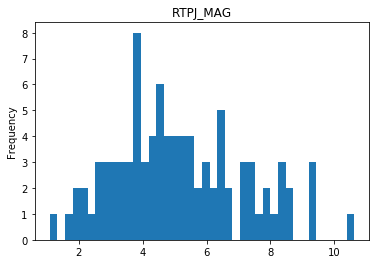

In [51]:
import matplotlib.pyplot as plt
import scipy
# make histogram of df column
# df = df.astype(np.float)

#fig, ax = plt.subplots()
#ax = df.hist('TPJ_LAT_0.01', ax=ax, bins=50) #, bottom=0.1)

title = 'RTPJ_MAG'
ax = df[title].plot.hist(bins=40, title=title) 
#ax.set_yscale('log')

# xlim=(-1,1)

In [15]:
# scipy.stats.normaltest(df.hist('DMPFC_LAT_0.01'))
#scipy.stats.normaltest(df.hist('DMPFC_LAT_0.01'))
subject+task+'_LAT_SUM_STATS_final.csv'
# temp = df['LTPJ_MAG'].tolist()
# print(temp)
# scipy.stats.normaltest(temp)

'SAX_OA_071tomloc_LAT_SUM_STATS_final.csv'

In [81]:
scipy.stats.normaltest( [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 101])

NormaltestResult(statistic=198.91121826624527, pvalue=6.411767401660949e-44)